# Generate Graphs for Connected Component

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as NX
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import time
import datetime
import os,sys

OUTPUT_DIR="/work/01131/tg804093/graph"

try:
    os.makedirs(OUTPUT_DIR)
except:
    pass

# Characteristics of Leaflet Finder Graphs

    count    24056.000000
    mean         5.971566
    std          1.305737
    min          2.000000
    25%          5.000000
    50%          6.000000
    75%          7.000000
    max         12.000000
    
    
Using NetworkX the largest graph that can be generated on a Stampede node with 32 GB memory is **10 Mio** nodes.

In [2]:
#OUTPUT_DIR=os.path.join(os.getcwd(), "data")


#number_of_nodes=[    10000, 
#                    100000,
#                   1000000,
#                  10000000,
#                 100000000,
#                1000000000]
number_of_nodes=[10]

captured_times = {}
for number in number_of_nodes:
    start = time.time()
    degree_vector = np.random.normal(5.971566, 1.305737, number)
    graph = NX.expected_degree_graph(degree_vector)
    NX.write_edgelist(graph,
                      os.path.join(OUTPUT_DIR, 
                        "graph_edges_%d_%d.csv"%(number, NX.number_of_edges(graph))),
                      delimiter=",")
    
    end = time.time()
    captured_times[number]=end-start

In [21]:
str(captured_times)

'{20000: 1.1708459854125977, 40000: 2.56634783744812, 640000: 49.59387397766113, 80000: 5.55070686340332, 1280000: 108.38637399673462, 160000: 11.38257098197937, 10000: 1.0456390380859375, 320000: 23.956480979919434}'

In [24]:
!ls -lta {OUTPUT_DIR}

total 124280
-rw-------  1 tg804093 G-800683 65940271 Aug  1 13:41 graph_edges_1280000_3819403.csv
drwx------  2 tg804093 G-800683     4096 Aug  1 13:40 .
-rw-------  1 tg804093 G-800683 31826390 Aug  1 13:39 graph_edges_640000_1911152.csv
-rw-------  1 tg804093 G-800683 15576940 Aug  1 13:38 graph_edges_320000_955401.csv
-rw-------  1 tg804093 G-800683  7461452 Aug  1 13:38 graph_edges_160000_478000.csv
-rw-------  1 tg804093 G-800683  3504310 Aug  1 13:38 graph_edges_80000_238049.csv
-rw-------  1 tg804093 G-800683  1727441 Aug  1 13:37 graph_edges_40000_119599.csv
-rw-------  1 tg804093 G-800683   819338 Aug  1 13:37 graph_edges_20000_58979.csv
-rw-------  1 tg804093 G-800683   379940 Aug  1 13:37 graph_edges_10000_29735.csv
drwx------ 12 tg804093 G-800683     4096 Aug  1 13:31 ..


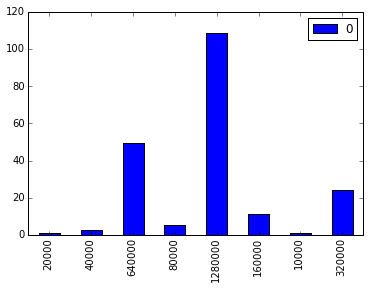

In [26]:
pd = DataFrame.from_dict(captured_times, orient="index")
pd.plot(kind="bar")

## Spark

In [1]:
#SPARK_HOME="/usr/local/Cellar/apache-spark/1.4.1/libexec"
#os.environ["SPARK_HOME"]=SPARK_HOME
%run ../util/init_spark.py
%run ../env.py
print "SPARK HOME: %s"%os.environ["SPARK_HOME"]

sc = SparkContext("spark://129.114.82.28:7077",
                  "Pilot-Spark")

SPARK HOME: /home1/01131/tg804093/src/supercomputing2015-tutorial/02_hadoop_on_hpc/work/spark-1.4.1-bin-hadoop2.6


In [ ]:
%%time
from pyspark.mllib.random import RandomRDDs
import random

NUMBER_NODES_SCENARIO=[1000000000, 10000000000, 10000000000, 1000000000000]
NUMBER_PARTITIONS=32

print "Generate Scenarios: %s to OUTPUT directory: %s"%(str(NUMBER_NODES_SCENARIO, OUTPUT_DIR))

def generate_random_edges(tuple):
    """(source, <number of edges for source)"""
    edges = []
    source = tuple[0]
    for i in range(0, tuple[1]):
        destination = random.randrange(NUMBER_NODES)
        if destination > source: 
            edges.append((source, destination))
            # counter.add(1)
    return edges


measurements= {}
for i in NUMBER_NODES_SCENARIO:
    #counter = sc.accumulator(0)
    NUMBER_NODES = i
    start = time.time()
    random_edges_rdd = RandomRDDs.normalRDD(sc, size=NUMBER_NODES, numPartitions=NUMBER_PARTITIONS) \
                             .map(lambda v: int(round(5.971566  + 1.305737  * v)))\
                             .zipWithIndex()\
                             .map(lambda a: (a[1], a[0]))\
                             .flatMap(lambda n: generate_random_edges(n))\
                             .map(lambda tuple: "%s,%s"%(tuple))
                              
    number_edges = random_edges_rdd.count()
    #number_edges = counter.value
    print "Number of Edges: %d"%number_edges

    random_edges_rdd.saveAsTextFile(os.path.join(OUTPUT_DIR, 
                        "graph_edges_%d_%d.csv"%(NUMBER_NODES, number_edges)))
    end = time.time()
    measurements[NUMBER_NODES]=end-start

    
print "Framework, NumberComputeNodes, NumberPartitions, NumberGraphNodes, Time"
for key, value in measurements.iteritems():
    print "Spark, 2, %d, %d, %.2f"%(NUMBER_PARTITIONS, key, value)